In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/engage-2-value-from-clicks-to-conversions/sample_submission.csv
/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv
/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv


# Importing required libraries

In [2]:
#Importing some required modules

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import RidgeCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor, StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

# Loading train and test datasets and defining our target:

In [3]:
# defining train and test datasets
train_df = pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv')
test_df = pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv')

In [4]:
# Defining the target column
TARGET = 'purchaseValue' 

In [5]:
pd.set_option('display.max_columns', None)
train_df.sample(5)

,trafficSource.isTrueDirect,purchaseValue,browser,device.screenResolution,trafficSource.adContent,trafficSource.keyword,screenSize,geoCluster,trafficSource.adwordsClickInfo.slot,device.mobileDeviceBranding,device.mobileInputSelector,userId,trafficSource.campaign,device.mobileDeviceMarketingName,geoNetwork.networkDomain,gclIdPresent,device.operatingSystemVersion,sessionNumber,device.flashVersion,geoNetwork.region,trafficSource,totals.visits,geoNetwork.networkLocation,sessionId,os,geoNetwork.subContinent,trafficSource.medium,trafficSource.adwordsClickInfo.isVideoAd,browserMajor,locationCountry,device.browserSize,trafficSource.adwordsClickInfo.adNetworkType,socialEngagementType,geoNetwork.city,trafficSource.adwordsClickInfo.page,geoNetwork.metro,pageViews,locationZone,device.mobileDeviceModel,trafficSource.referralPath,totals.bounces,date,device.language,deviceType,userChannel,device.browserVersion,totalHits,device.screenColors,sessionStart,geoNetwork.continent,device.isMobile,new_visits
89603,True,0.0,Chrome,not available in demo dataset,NaN,NaN,medium,Region_4,NaN,not available in demo dataset,not available in demo dataset,81586,(not set),not available in demo dataset,domain2,0,not available in demo dataset,2,not available in demo dataset,not available in demo dataset,(direct),1,not available in demo dataset,1487467454,iOS,Northern America,(none),NaN,not available in demo dataset,United States,not available in demo dataset,NaN,Not Socially Engaged,not available in demo dataset,NaN,not available in demo dataset,1.0,8,not available in demo dataset,NaN,1.0,20170218,not available in demo dataset,mobile,Direct,not available in demo dataset,1,not available in demo dataset,1487467454,Americas,True,NaN
80457,NaN,0.0,Chrome,not available in demo dataset,NaN,(not provided),medium,Region_4,NaN,not available in demo dataset,not available in demo dataset,9087,(not set),not available in demo dataset,domain3,0,not available in demo dataset,1,not available in demo dataset,(not set),google,1,not available in demo dataset,1471490807,Macintosh,Southeast Asia,organic,NaN,not available in demo dataset,Singapore,not available in demo dataset,NaN,Not Socially Engaged,Singapore,NaN,(not set),1.0,8,not available in demo dataset,NaN,1.0,20160817,not available in demo dataset,desktop,Organic Search,not available in demo dataset,1,not available in demo dataset,1471490807,Asia,False,1.0
79691,NaN,0.0,Chrome,not available in demo dataset,NaN,(not provided),medium,Region_4,NaN,not available in demo dataset,not available in demo dataset,54902,(not set),not available in demo dataset,domain2,0,not available in demo dataset,1,not available in demo dataset,State of Sao Paulo,google,1,not available in demo dataset,1482340352,Linux,South America,organic,NaN,not available in demo dataset,Brazil,not available in demo dataset,NaN,Not Socially Engaged,Sao Paulo,NaN,(not set),4.0,8,not available in demo dataset,NaN,NaN,20161221,not available in demo dataset,desktop,Organic Search,not available in demo dataset,4,not available in demo dataset,1482340352,Americas,False,1.0
104812,True,0.0,Chrome,not available in demo dataset,NaN,NaN,medium,Region_2,NaN,not available in demo dataset,not available in demo dataset,90589,(not set),not available in demo dataset,domain3,0,not available in demo dataset,1,not available in demo dataset,California,(direct),1,not available in demo dataset,1472075104,Linux,Northern America,(none),NaN,not available in demo dataset,United States,not available in demo dataset,NaN,Not Socially Engaged,Mountain View,NaN,San Francisco-Oakland-San Jose CA,4.0,8,not available in demo dataset,NaN,NaN,20160824,not available in demo dataset,desktop,Direct,not available in demo dataset,5,not available in demo dataset,1472075107,Americas,False,1.0
16757,NaN,0.0,Chrome,not available in demo dataset,NaN,NaN,medium,Region_1,NaN,not available in demo dataset,not available in demo dataset,105245,(not set),not available in demo dataset,domain3,0,not available in demo da

The sample rows show that most sessions have zero purchaseValue, and ad-related fields like trafficSource.adContent, keyword, and adwordsClickInfo.* are frequently missing or (not set).
Sessions span across various channels like Direct, Referral, and Organic, but key attribution data is sparse.
pageViews and totals.bounces vary, suggesting diverse user engagement behavior across sources and devices. A lot of values in the dataset are "not available in demo dataset", which need to be removed. 

# Exploratory Data Analysis:

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116023 entries, 0 to 116022
Data columns (total 52 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   trafficSource.isTrueDirect                    42890 non-null   object 
 1   purchaseValue                                 116023 non-null  float64
 2   browser                                       116023 non-null  object 
 3   device.screenResolution                       116023 non-null  object 
 4   trafficSource.adContent                       2963 non-null    object 
 5   trafficSource.keyword                         44162 non-null   object 
 6   screenSize                                    116023 non-null  object 
 7   geoCluster                                    116023 non-null  object 
 8   trafficSource.adwordsClickInfo.slot           4281 non-null    object 
 9   device.mobileDeviceBranding                   11

Insight: The dataset has 116,023 entries and 52 features, but many columns related to ads and referrals have high missing values. Core session, device, and geography features are fully populated. Modeling should focus on well-populated columns, with sparse ones handled carefully or excluded.

In [7]:
train_df.describe()

,purchaseValue,userId,gclIdPresent,sessionNumber,totals.visits,sessionId,trafficSource.adwordsClickInfo.page,pageViews,locationZone,totals.bounces,date,totalHits,sessionStart,new_visits
count,1.160230e+05,116023.000000,116023.000000,116023.000000,116023.0,1.160230e+05,4281.000000,116015.000000,116023.0,47148.0,1.160230e+05,116023.000000,1.160230e+05,80518.0
mean,2.656393e+07,61094.356231,0.037019,2.691311,1.0,1.493429e+09,1.019622,8.412352,8.0,1.0,2.016860e+07,10.607371,1.493429e+09,1.0
std,2.051825e+08,35240.756859,0.188808,10.451613,0.0,1.528798e+07,0.174517,14.344937,0.0,0.0,6.182322e+03,19.629576,1.528798e+07,0.0
min,0.000000e+00,0.000000,0.000000,1.000000,1.0,1.470035e+09,1.000000,1.000000,8.0,1.0,2.016080e+07,1.000000,1.470035e+09,1.0
25%,0.000000e+00,30603.500000,0.000000,1.000000,1.0,1.480066e+09,1.000000,1.000000,8.0,1.0,2.016112e+07,1.000000,1.480066e+09,1.0
50%,0.000000e+00,61014.000000,0.000000,1.000000,1.0,1.491646e+09,1.000000,2.000000,8.0,1.0,2.017041e+07,2.000000,1.491646e+09,1.0
75%,0.000000e+00,91616.500000,0.000000,2.000000,1.0,1.505079e+09,1.000000,10.000000,8.0,1.0,2.017091e+07,12.000000,1.505079e+09,1.0
max,2.312950e+10,122276.000000,1.000000,447.000000,1.0,1.525157e+09,5.000000,469.000000,8.0,1.0,2.018043e+07,500.000000,1.525157e+09,1.0


Insight: This is a highly zero-inflated dataset. Most users have low or zero purchaseValue, with a few high-value outliers. Sessions are mostly single visits (totals.visits = 1) and bounce frequently. new_visits is consistently marked as 1, and AdWords-related data (gclIdPresent, adwordsClickInfo.page) is sparse.

In [8]:
train_df.isnull().sum()*100/len(train_df)

trafficSource.isTrueDirect                      63.033192
purchaseValue                                    0.000000
browser                                          0.000000
device.screenResolution                          0.000000
trafficSource.adContent                         97.446196
trafficSource.keyword                           61.936857
screenSize                                       0.000000
geoCluster                                       0.000000
trafficSource.adwordsClickInfo.slot             96.310214
device.mobileDeviceBranding                      0.000000
device.mobileInputSelector                       0.000000
userId                                           0.000000
trafficSource.campaign                           0.000000
device.mobileDeviceMarketingName                 0.000000
geoNetwork.networkDomain                         0.000000
gclIdPresent                                     0.000000
device.operatingSystemVersion                    0.000000
sessionNumber 

Several ad-related features (like trafficSource.adContent and adwordsClickInfo.*) have over 96% missing values, making them unreliable for modeling.
User, device, and geography data are fully available, making them more dependable.
Key behavioral features like new_visits and totals.bounces also have significant missingness (30–60%), which may require imputation or exclusion.

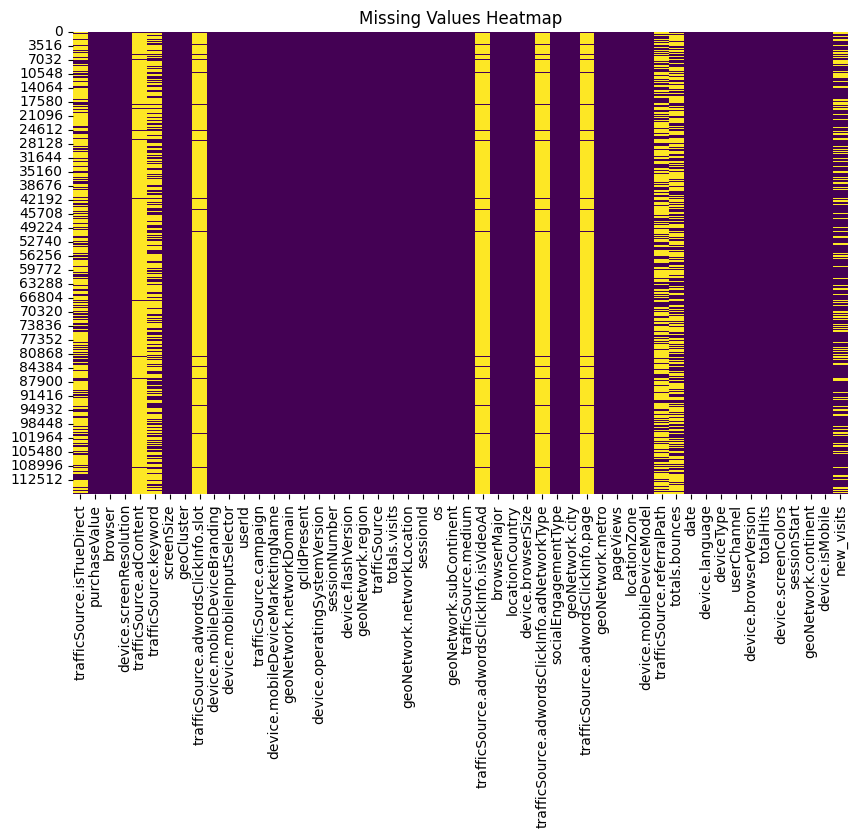

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(train_df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()

The heatmap reveals heavy missingness in specific columns, particularly those related to advertising data (adContent, keyword, adwordsClickInfo.*).
Most other columns are nearly fully populated, highlighting a clear divide between core user/session data and sparse ad attribution fields.
This suggests that ad-related features may need to be dropped or imputed selectively during preprocessing to avoid noise in modeling.

In [10]:
train_df.nunique()

trafficSource.isTrueDirect                           1
purchaseValue                                     6766
browser                                             34
device.screenResolution                              1
trafficSource.adContent                             53
trafficSource.keyword                              566
screenSize                                           1
geoCluster                                           5
trafficSource.adwordsClickInfo.slot                  3
device.mobileDeviceBranding                          1
device.mobileInputSelector                           1
userId                                          100499
trafficSource.campaign                              28
device.mobileDeviceMarketingName                     1
geoNetwork.networkDomain                             3
gclIdPresent                                         2
device.operatingSystemVersion                        1
sessionNumber                                      230
device.fla

Many features (e.g. device.screenResolution, totals.visits, deviceType) have only one unique value, offering no variance and are candidates for removal.
High-cardinality columns like userId, sessionId, and referralPath likely serve as identifiers and may not contribute meaningfully to modeling.
Only a few columns such as browser, geoNetwork.city, and trafficSource.keyword show rich diversity and could be valuable for feature extraction.

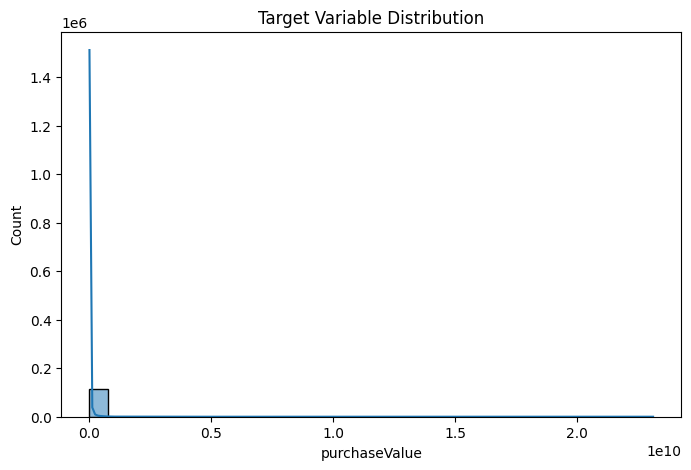

In [11]:
plt.figure(figsize=(8, 5))
sns.histplot(train_df[TARGET], kde=True, bins=30)
plt.title("Target Variable Distribution")
plt.show()

The purchaseValue target is heavily right-skewed with a long tail and a huge concentration of near-zero values (likely zero-inflated).
This calls for log transformation, zero-inflated models, or classification + regression hybrid to handle the imbalance effectively.

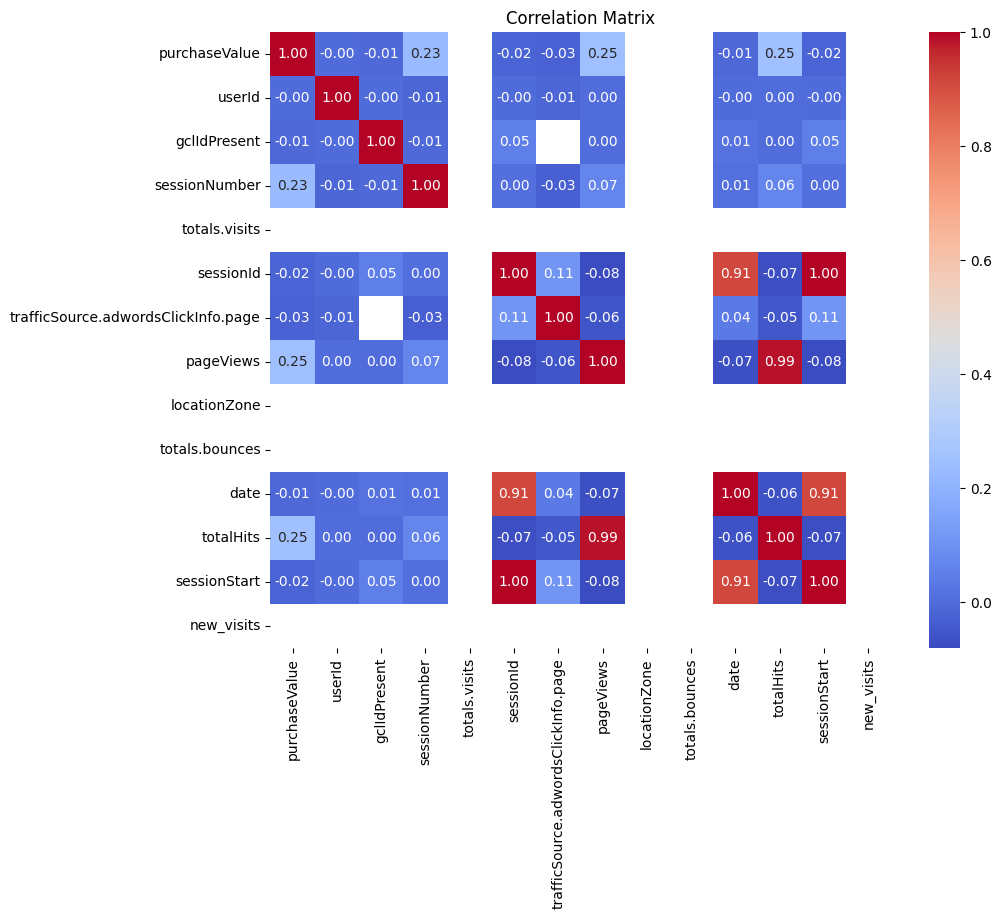

In [12]:
num_df = train_df.select_dtypes('number')
corr = num_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

Only pageViews, totalHits, and sessionNumber show mild positive correlation (0.23–0.25) with purchaseValue.
Most other variables, like userId, sessionId, and bounces, have negligible or no correlation.
Highly collinear pairs like totalHits & pageViews (0.99) and date & sessionStart (0.91) should be handled to avoid redundancy.

# Preprocessing:

In [13]:
# Replacing junk values with NaN
train_df.replace('?', np.nan, inplace=True)
test_df.replace('?', np.nan, inplace=True)
train_df.replace('not available in demo dataset', np.nan, inplace= True)
test_df.replace('not available in demo dataset', np.nan, inplace=True)

In [14]:
# Dropping columns with more than 95% missing values
threshold = 0.95 * len(train_df)
missing_train = train_df.isnull().sum()
missing_cols = missing_train[missing_train > threshold].index.tolist()
train_df.drop(columns=missing_cols, inplace=True)
test_df.drop(columns=missing_cols, inplace=True)

In [15]:
# Dropping rows with missing target value
train_df.dropna(subset=[TARGET], inplace=True)

In [16]:
# Filling missing values only for columns that exist in both train and test
common_cols = train_df.columns.intersection(test_df.columns)

for col in common_cols:
    if pd.api.types.is_object_dtype(train_df[col]):
        train_df[col].fillna('missing', inplace=True)
        test_df[col].fillna('missing', inplace=True)
    else:
        train_df[col].fillna(0, inplace=True)
        test_df[col].fillna(0, inplace=True)

In [17]:
# Encoding categorical variables
categorical_cols = train_df.select_dtypes(include=['object']).columns
train_df = pd.get_dummies(train_df, columns=categorical_cols)
test_df = pd.get_dummies(test_df, columns=categorical_cols)

In [18]:
#removing special characters from column names
train_df.columns = train_df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
test_df.columns = test_df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)

In [19]:
# Removing duplicate columns in train_df and test_df
train_df = train_df.loc[:, ~train_df.columns.duplicated()]
test_df = test_df.loc[:, ~test_df.columns.duplicated()]

# Feature Engineering:

In [20]:
train_df['date'] = train_df['date'].astype(str)
train_df['date'] = pd.to_datetime(train_df['date'], format='%Y%m%d', errors='coerce')

test_df['date'] = test_df['date'].astype(str)
test_df['date'] = pd.to_datetime(test_df['date'], format='%Y%m%d', errors='coerce')

In [21]:
train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['dayofweek'] = train_df['date'].dt.dayofweek
train_df['is_weekend'] = (train_df['dayofweek'] >= 5).astype(int)
train_df['is_month_end'] = train_df['date'].dt.is_month_end.astype(int)

test_df['year'] = test_df['date'].dt.year
test_df['month'] = test_df['date'].dt.month
test_df['dayofweek'] = test_df['date'].dt.dayofweek
test_df['is_weekend'] = (test_df['dayofweek'] >= 5).astype(int)
test_df['is_month_end'] = test_df['date'].dt.is_month_end.astype(int)

In [22]:
train_df.drop(columns='date', inplace=True)
test_df.drop(columns='date', inplace=True)

# Training a baseline LightGBM model to obtain top features:

In [23]:
# Separating features and target
X = train_df.drop(columns=['purchaseValue'])
y = train_df['purchaseValue']

In [24]:


model = LGBMRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=-1
)

model.fit(X, y)

LGBMRegressor(colsample_bytree=0.8, max_depth=6, n_jobs=-1, random_state=42,
              subsample=0.9, verbosity=-1)

                    Feature  Importance
2             sessionNumber         326
8                 totalHits         305
5                 pageViews         265
4                 sessionId         115
0                    userId          91
3175     userChannel_Direct          65
3189              dayofweek          60
3188                  month          58
1974  geoNetwork_city_Salem          35
1195           os_Macintosh          27


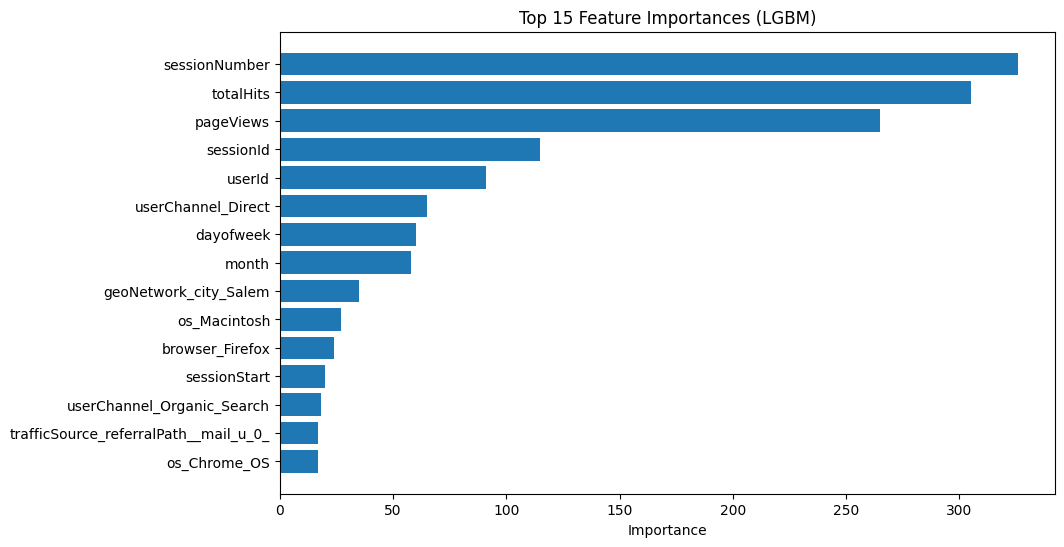

In [25]:
# Getting important features
importances = model.feature_importances_
feature_names = X.columns

# Creating a DataFrame for sorting
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Displaying top features
print(feature_importance_df.head(10))

# Plotting important features for better analysis
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.barh(feature_importance_df['Feature'][:15][::-1], feature_importance_df['Importance'][:15][::-1])
plt.xlabel("Importance")
plt.title("Top 15 Feature Importances (LGBM)")
plt.show()

# Splitting for a validation set:

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size = 0.2, random_state = 42)

# Creating a dataframe with top features:

In [27]:
#Creating dataframe with top features only

top_features = feature_importance_df['Feature'].head(20).tolist()

X_train_top = X_train[top_features]
X_val_top = X_val[top_features]
X_test_top = test_df[top_features]

# Adding some useful feature interactions to improve performance:

In [28]:
#Adding some feature interactions to improve model performance
X_train_eng = X_train_top.copy()
X_train_eng['hits_per_view'] = X_train_eng['totalHits'] / (X_train_eng['pageViews'] + 1)
X_train_eng['session_hits_ratio'] = X_train_eng['sessionNumber'] / (X_train_eng['totalHits'] + 1)
X_train_eng['interaction_score'] = X_train_eng['sessionNumber'] * X_train_eng['pageViews']
X_train_eng['log_session'] = np.log1p(X_train_eng['sessionNumber'])
X_train_eng['weekday_session'] = X_train_eng['dayofweek'] * X_train_eng['sessionNumber']
X_train_eng['month_session'] = X_train_eng['month'] * X_train_eng['sessionNumber']

X_val_eng = X_val_top.copy()
X_val_eng['hits_per_view'] = X_val_eng['totalHits'] / (X_val_eng['pageViews'] + 1)
X_val_eng['session_hits_ratio'] = X_val_eng['sessionNumber'] / (X_val_eng['totalHits'] + 1)
X_val_eng['interaction_score'] = X_val_eng['sessionNumber'] * X_val_eng['pageViews']
X_val_eng['log_session'] = np.log1p(X_val_eng['sessionNumber'])
X_val_eng['weekday_session'] = X_val_eng['dayofweek'] * X_val_eng['sessionNumber']
X_val_eng['month_session'] = X_val_eng['month'] * X_val_eng['sessionNumber']

X_test_eng = X_test_top.copy()
X_test_eng['hits_per_view'] = X_test_eng['totalHits'] / (X_test_eng['pageViews'] + 1)
X_test_eng['session_hits_ratio'] = X_test_eng['sessionNumber'] / (X_test_eng['totalHits'] + 1)
X_test_eng['interaction_score'] = X_test_eng['sessionNumber'] * X_test_eng['pageViews']
X_test_eng['log_session'] = np.log1p(X_test_eng['sessionNumber'])
X_test_eng['weekday_session'] = X_test_eng['dayofweek'] * X_test_eng['sessionNumber']
X_test_eng['month_session'] = X_test_eng['month'] * X_test_eng['sessionNumber']

In [29]:
#Ensuring column alignment
final_columns = X_train_eng.columns.tolist()

X_train_final = X_train_eng[final_columns]
X_val_final = X_val_eng[final_columns]
X_test_final = X_test_eng[final_columns]

# Training the final list of models:

In [30]:
# Initializing models
xgb_model = XGBRegressor(n_estimators= 395, learning_rate= 0.20, max_depth= 13, subsample= 0.8, colsample_bytree= 0.6, reg_alpha= 1, reg_lambda= 4.25, random_state = 42, n_jobs = -1)
lgb_model = LGBMRegressor(objective='regression', num_leaves= 120, learning_rate= 0.2, subsample= 0.1, colsample_bytree= 0.75, n_estimators= 420, max_depth= 19, min_child_samples= 5, reg_alpha= 3.5, reg_lambda= 8.3, n_jobs = -1, verbosity = -1, random_state = 42)
rf_model = RandomForestRegressor(n_estimators= 150, max_depth= 27, min_samples_split= 2, min_samples_leaf= 1, max_features= 'log2')
et_model = ExtraTreesRegressor(n_estimators= 300, max_depth= 28, min_samples_split= 2, min_samples_leaf= 1, max_features= 'sqrt', bootstrap= False, random_state=42, n_jobs=-1)
hgb_model = HistGradientBoostingRegressor(max_iter=500, max_depth=12, min_samples_leaf=20, learning_rate=0.2, random_state=42)

In [31]:
# Fitting models
xgb_model.fit(X_train_final, y_train)
lgb_model.fit(X_train_final, y_train)
rf_model.fit(X_train_final, y_train)
et_model.fit(X_train_final, y_train)
hgb_model.fit(X_train_final, y_train)

HistGradientBoostingRegressor(learning_rate=0.2, max_depth=12, max_iter=500,
                              random_state=42)

# Evaluating the models based on the validation set:

In [32]:
def evaluate(model, name):
    preds = model.predict(X_val_final)
    r2 = r2_score(y_val, preds)
    rmse = mean_squared_error(y_val, preds, squared = False)
    return name, r2, rmse

results = [
    evaluate(xgb_model, 'XGBoost'),
    evaluate(lgb_model, 'LightGBM'),
    evaluate(rf_model, 'Random Forest'),
    evaluate(et_model, 'Extra Trees'),
    evaluate(hgb_model, 'HistGradientBoosting')
]

# Displays results
results_df = pd.DataFrame(results, columns=['Model', 'R²', 'RMSE']).sort_values(by='R²', ascending=False)
print(results_df)

                  Model        R²          RMSE
3           Extra Trees  0.467803  1.586070e+08
4  HistGradientBoosting  0.336000  1.771618e+08
2         Random Forest  0.333241  1.775295e+08
1              LightGBM  0.233155  1.903881e+08
0               XGBoost  0.221827  1.917892e+08


# Adding interactions to the full dataset (X) for final training: 

In [33]:
X_train_prod = X[top_features]
X_train_prod_final = X_train_prod.copy()
X_train_prod_final['hits_per_view'] = X_train_prod_final['totalHits'] / (X_train_prod_final['pageViews'] + 1)
X_train_prod_final['session_hits_ratio'] = X_train_prod_final['sessionNumber'] / (X_train_prod_final['totalHits'] + 1)
X_train_prod_final['interaction_score'] = X_train_prod_final['sessionNumber'] * X_train_prod_final['pageViews']
X_train_prod_final['log_session'] = np.log1p(X_train_prod_final['sessionNumber'])
X_train_prod_final['weekday_session'] = X_train_prod_final['dayofweek'] * X_train_prod_final['sessionNumber']
X_train_prod_final['month_session'] = X_train_prod_final['month'] * X_train_prod_final['sessionNumber']

# Performing hyperparameter tuning on the LGBM Regressor for final training and prediction: 

In [34]:
# lgbm = LGBMRegressor(
#     objective='regression',
#     n_jobs=-1,
#     verbosity=-1,
#     random_state=42
# )


# param_grid = {
#     'num_leaves': [30, 60, 120],
#     'learning_rate': [0.1, 0.2, 0.3],
#     'max_depth': [10, 15, 19],
#     'n_estimators': [200, 300, 420],
# }

# grid_search = GridSearchCV(
#     estimator=lgbm,
#     param_grid=param_grid,
#     cv=3,
#     scoring='neg_root_mean_squared_error',  # or 'r2', 'neg_mean_absolute_error'
#     verbose=1,
#     n_jobs=-1
# )

# grid_search.fit(X_train_prod_final, y)

# best_lgbm_model = grid_search.best_estimator_

In [35]:
lgbm_final_model = LGBMRegressor(objective='regression', num_leaves= 120, learning_rate= 0.2, subsample= 0.1, colsample_bytree= 0.75, n_estimators= 420, max_depth= 19, min_child_samples= 5, reg_alpha= 3.5, reg_lambda= 8.3, n_jobs = -1, verbosity = -1, random_state = 42)
lgbm_final_model.fit(X_train_prod_final,y)

LGBMRegressor(colsample_bytree=0.75, learning_rate=0.2, max_depth=19,
              min_child_samples=5, n_estimators=420, n_jobs=-1, num_leaves=120,
              objective='regression', random_state=42, reg_alpha=3.5,
              reg_lambda=8.3, subsample=0.1, verbosity=-1)

In [36]:
stack_model = StackingRegressor(
    estimators=[
        ('lgbm', LGBMRegressor(objective='regression', num_leaves= 122, learning_rate= 0.1843779523211995, subsample= 0.988660135404805, colsample_bytree= 0.7341396274697101, n_estimators= 420, max_depth= 19, min_child_samples= 5, reg_alpha= 3.4920312155481774, reg_lambda= 8.332441859445556, n_jobs = -1, verbosity = -1, random_state = 42)),
        ('et', ExtraTreesRegressor(n_estimators= 300, max_depth= 28, min_samples_split= 2, min_samples_leaf= 1, max_features= 'sqrt', bootstrap= False, random_state=42, n_jobs=-1)),
        ('xgb', XGBRegressor(n_estimators= 395, learning_rate= 0.20169195812550667, max_depth= 13, subsample= 0.8860075796421873, colsample_bytree= 0.5968657591929026, reg_alpha= 1.0401036716631193, reg_lambda= 4.264797498987966, random_state = 42, n_jobs = -1))
    ],
    final_estimator=RandomForestRegressor(n_estimators= 150, max_depth= 27, min_samples_split= 2, min_samples_leaf= 1, max_features= 'log2'),
    passthrough=False,
    n_jobs=-1
)

stack_model.fit(X_train_prod_final,y)

StackingRegressor(estimators=[('lgbm',
                               LGBMRegressor(colsample_bytree=0.7341396274697101,
                                             learning_rate=0.1843779523211995,
                                             max_depth=19, min_child_samples=5,
                                             n_estimators=420, n_jobs=-1,
                                             num_leaves=122,
                                             objective='regression',
                                             random_state=42,
                                             reg_alpha=3.4920312155481774,
                                             reg_lambda=8.332441859445556,
                                             subsample=0.988660135404805,
                                             verbosity=-1)),
                              ('et',
                               ExtraTre...
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=13,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=395, n_jobs=-1,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                  final_estimator=RandomForestRegressor(max_depth=27,
                                                        max_features='log2',
                                                        n_estimators=150),
                  n_jobs=-1)

# Prediction on test set and submission:

In [37]:
# Predicting on test set
test_preds = lgbm_final_model.predict(X_test_final)

In [38]:
# Saving predictions
submission = pd.DataFrame({
    "id": range(0,test_df.shape[0]),
    'purchaseValue': test_preds
})
submission['purchaseValue'] = submission['purchaseValue'].clip(lower=0)
submission.to_csv('submission.csv', index=False)
print("Submission file saved as submission.csv")

Submission file saved as submission.csv
